# Coffee Shop Sales Data Clustering
### 1.data processing

In [ ]:
#import necessary packages
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#load-in dataset of US coffee shop sales
data = pd.read_excel("/content/Coffee Shop Sales.xlsx")
data.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [ ]:
#data cleaning
data['hour'] = data['transaction_time'].apply(lambda x: x.hour) #convert time into hours

#define different timeperiod
def get_time_period_by_hour(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

data['time_period'] = data['hour'].apply(get_time_period_by_hour)



In [ ]:
#group data
grouped = data.groupby(['store_location', 'time_period', 'product_category']).agg(
    total_qty=('transaction_qty', 'sum'),
    total_sales=('unit_price', 'sum'),
    avg_qty_per_transaction=('transaction_qty', 'mean'),
    avg_sales_per_transaction=('unit_price', 'mean'),
    transaction_count=('transaction_id', 'count')
).reset_index()


In [ ]:
grouped

,store_location,time_period,product_category,total_qty,total_sales,avg_qty_per_transaction,avg_sales_per_transaction,transaction_count
0,Astoria,Afternoon,Bakery,3051,10406.00,1.038108,3.540660,2939
1,Astoria,Afternoon,Branded,88,1763.00,1.000000,20.034091,88
2,Astoria,Afternoon,Coffee,12291,25068.25,1.484420,3.027566,8280
3,Astoria,Afternoon,Coffee beans,125,2647.70,1.000000,21.181600,125
4,Astoria,Afternoon,Drinking Chocolate,2787,7629.50,1.512208,4.139718,1843
...,...,...,...,...,...,...,...,...
76,Lower Manhattan,Morning,Drinking Chocolate,3461,8570.75,1.675218,4.148475,2066
77,Lower Manhattan,Morning,Flavours,3217,1601.60,1.606893,0.800000,2002
78,Lower Manhattan,Morning,Loose Tea,257,2405.35,1.000000,9.359339,257
79,Lower Manhattan,Morning,Packaged Chocolate,122,1151.45,1.000000,9.438115,122


In [ ]:
grouped.to_csv("grouped.csv", index=False)

###2.standarlize data for clustering

In [ ]:

# One-hot encode categorical variables
categorical_cols = ['store_location', 'time_period', 'product_category']
numeric_cols = ['total_qty', 'total_sales', 'avg_qty_per_transaction',
                'avg_sales_per_transaction', 'transaction_count']

# Build the preprocessing pipeline: one-hot encoding + scaling
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(), categorical_cols)
])

# Preprocess the data
grouped_scaled = preprocessor.fit_transform(grouped)

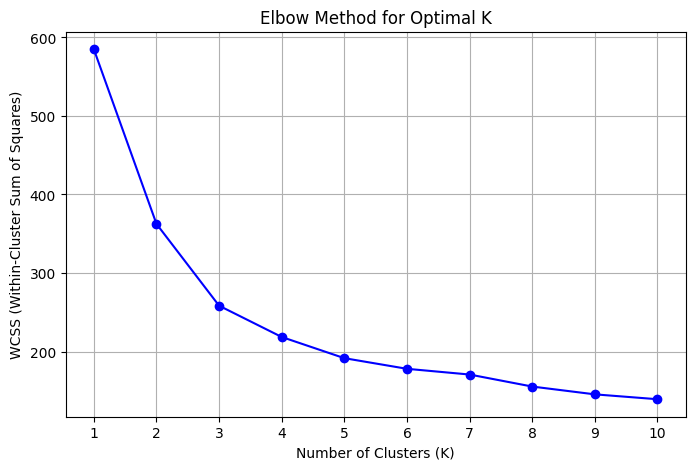

In [ ]:
#Test the best clusters number
wcss = []
K_range = range(1, 11)  # select 1~10 cluster number

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(grouped_scaled)
    wcss.append(kmeans.inertia_)  # WCSS as inertia

#draw elbow rule
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.xticks(K_range)
plt.grid(True)
plt.show()

###3. clustering

In [ ]:
#k-means clustering
from sklearn.cluster import KMeans

# set cluster number
n_clusters = 4

# clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
grouped['cluster'] = kmeans.fit_predict(grouped_scaled)

# see result
print(grouped['cluster'].value_counts())


cluster
1    27
2    26
0    18
3    10
Name: count, dtype: int64


In [ ]:
#save cluster data
output_path = 'grouped_with_clusters.csv'
grouped.to_csv(output_path, index=False)
print(f"Clustered data saved to {output_path}")

Clustered data saved to grouped_with_clusters.csv


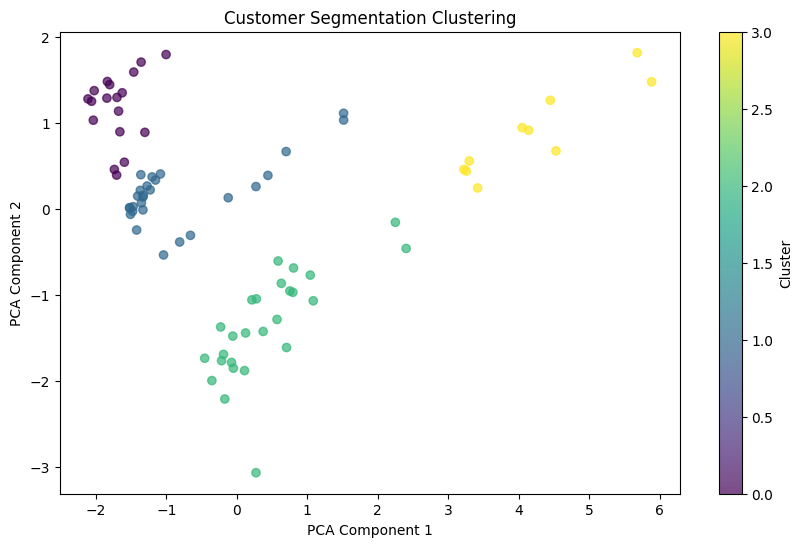

In [ ]:
#visualization result

# reduce dimension to visualize
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(grouped_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=grouped['cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segmentation Clustering')
plt.show()


# Customer Segmentation
###1.Cluster character


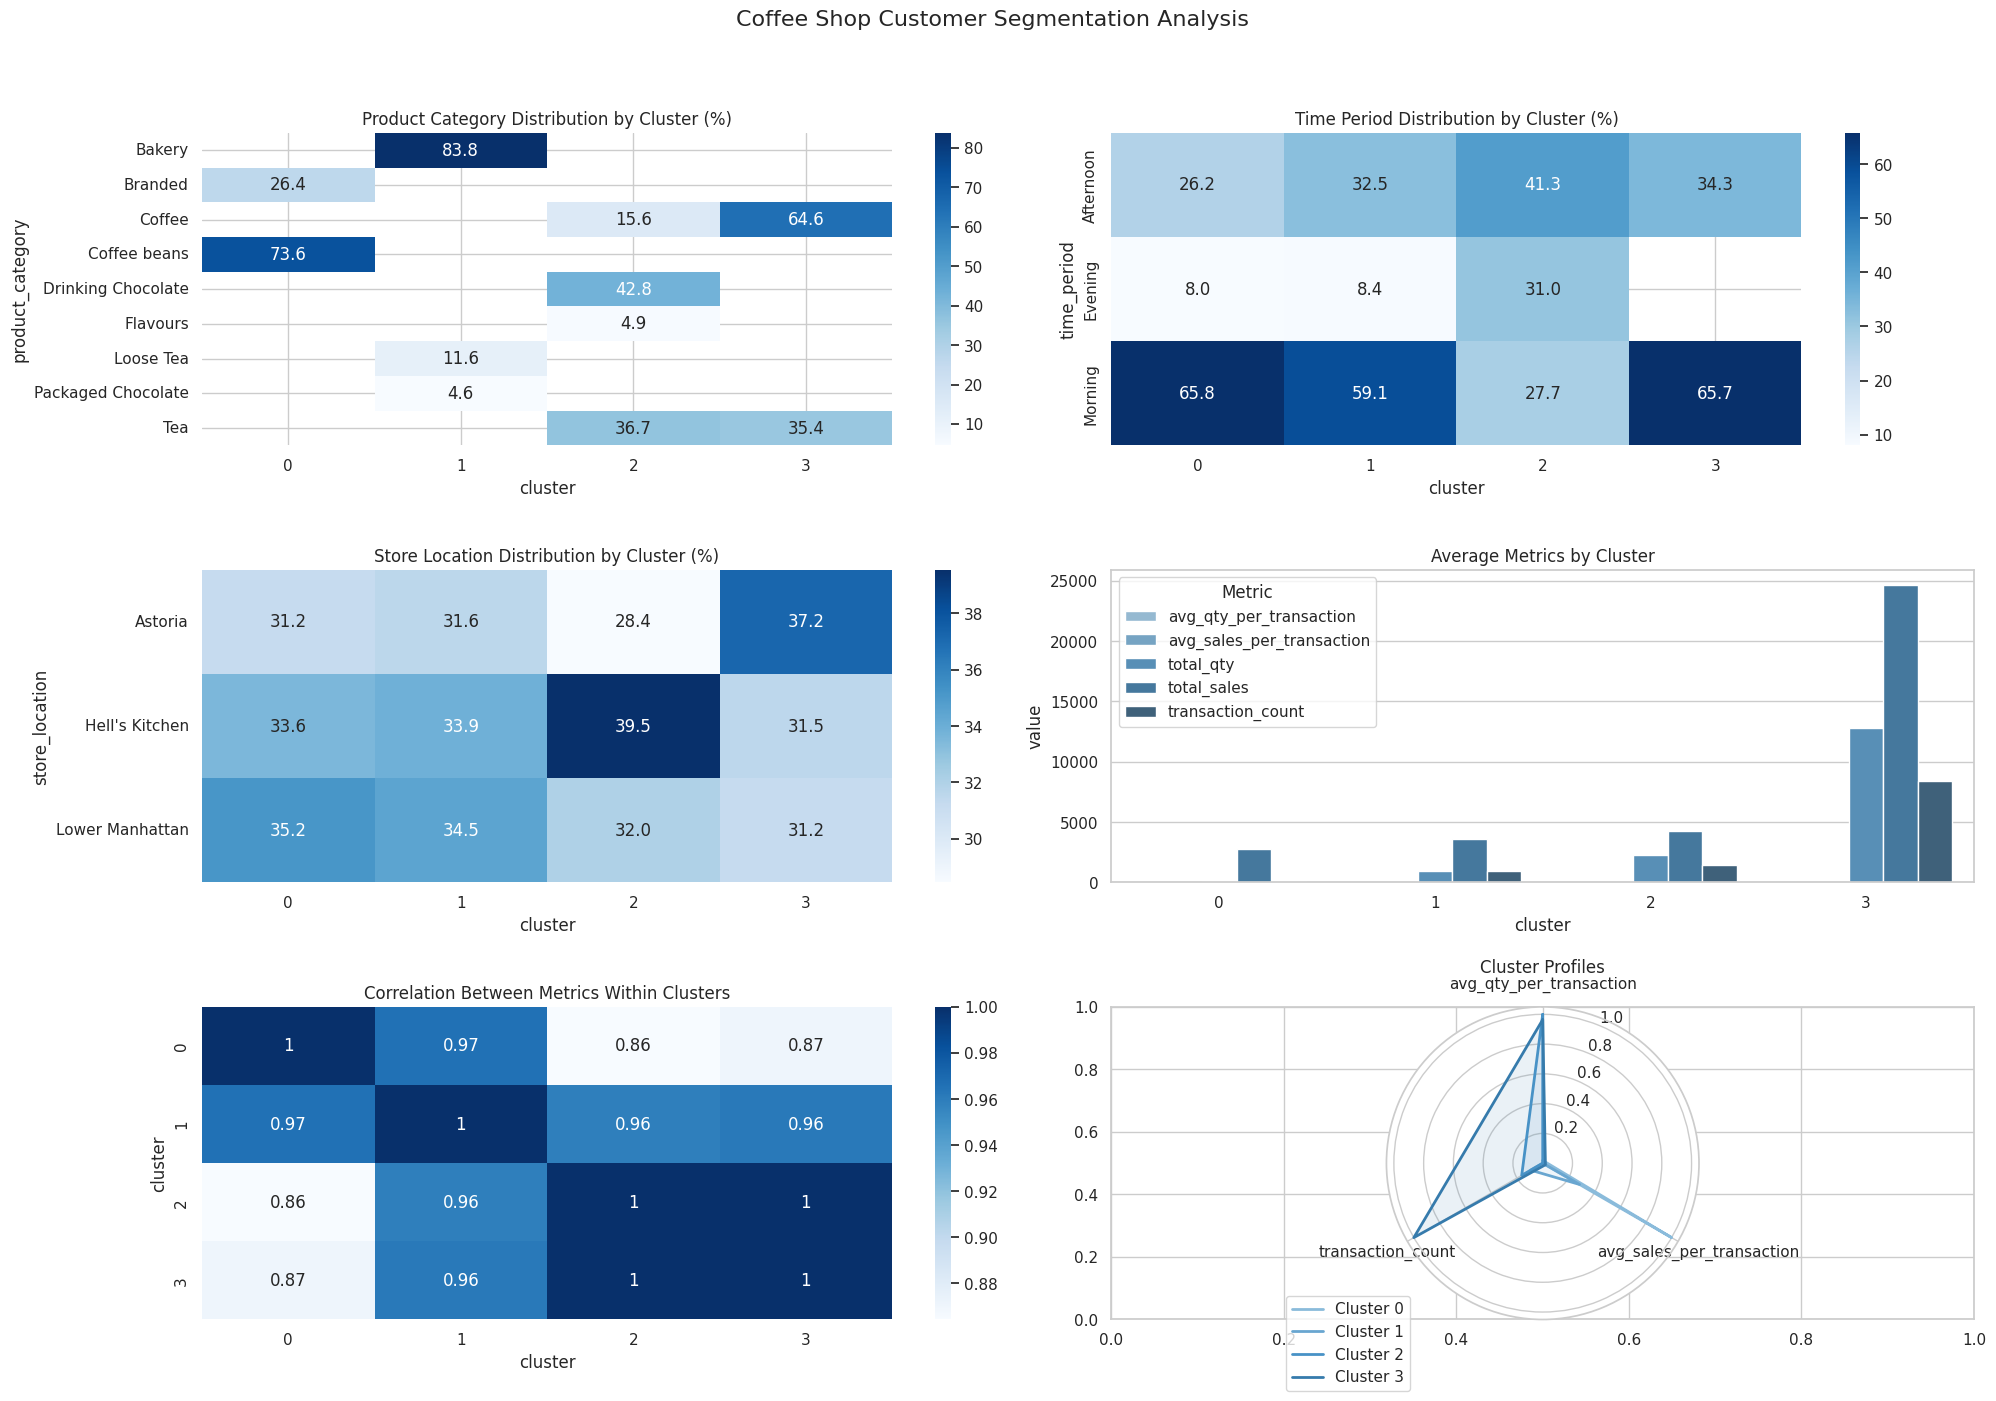

In [ ]:
df = grouped

# Set visualization style using Seaborn
sns.set_theme(style="whitegrid", palette="Blues_d")  # Set style and palette

# Create graph
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Coffee Shop Customer Segmentation Analysis', fontsize=16)

# 1. product distribution of each clusters
cluster_product = df.groupby(['cluster', 'product_category'])['total_sales'].sum().reset_index()
pivot_table = cluster_product.pivot(index='product_category', columns='cluster', values='total_sales')
pivot_table_percent = pivot_table.div(pivot_table.sum(), axis=1) * 100

sns.heatmap(pivot_table_percent, annot=True, fmt='.1f', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Product Category Distribution by Cluster (%)')

# 2. time period distribution
cluster_time = df.groupby(['cluster', 'time_period'])['transaction_count'].sum().reset_index()
pivot_time = cluster_time.pivot(index='time_period', columns='cluster', values='transaction_count')
pivot_time_percent = pivot_time.div(pivot_time.sum(), axis=1) * 100

sns.heatmap(pivot_time_percent, annot=True, fmt='.1f', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Time Period Distribution by Cluster (%)')

# 3. location distribution
cluster_location = df.groupby(['cluster', 'store_location'])['transaction_count'].sum().reset_index()
pivot_location = cluster_location.pivot(index='store_location', columns='cluster', values='transaction_count')
pivot_location_percent = pivot_location.div(pivot_location.sum(), axis=1) * 100

sns.heatmap(pivot_location_percent, annot=True, fmt='.1f', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Store Location Distribution by Cluster (%)')

# 4. key metrics comparation
metrics = ['avg_qty_per_transaction', 'avg_sales_per_transaction',
           'total_qty', 'total_sales', 'transaction_count']

cluster_metrics = df.groupby('cluster')[metrics].mean().reset_index()
cluster_metrics_melted = pd.melt(cluster_metrics, id_vars=['cluster'],
                                value_vars=metrics)

sns.barplot(x='cluster', y='value', hue='variable', data=cluster_metrics_melted, ax=axes[1, 1])
axes[1, 1].set_title('Average Metrics by Cluster')
axes[1, 1].legend(title='Metric')

# 5. relation analysis for clusters
cluster_corr = df.groupby('cluster')[metrics].mean().transpose()
sns.heatmap(cluster_corr.corr(), annot=True, cmap='Blues', ax=axes[2, 0])
axes[2, 0].set_title('Correlation Between Metrics Within Clusters')


# 6. radar chart to show characteristics
metrics_radar = ['avg_qty_per_transaction', 'avg_sales_per_transaction',
                'transaction_count']
metrics_scaled = cluster_metrics[metrics_radar].copy()

for col in metrics_radar:
    metrics_scaled[col] = (metrics_scaled[col] - metrics_scaled[col].min()) / \
                          (metrics_scaled[col].max() - metrics_scaled[col].min())
# prepare radar datas
# Use metrics_radar for calculating angles to ensure consistency
angles = np.linspace(0, 2*np.pi, len(metrics_radar), endpoint=False).tolist()
angles += angles[:1]  # close radar chart

metrics_scaled_values = metrics_scaled.values
gs = fig.add_gridspec(3, 2)
ax = fig.add_subplot(gs[2, 1], projection='polar')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_radar)

for i in range(len(metrics_scaled)):
    values = metrics_scaled_values[i].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

ax.set_title('Cluster Profiles', pad = 25)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('coffee_shop_segmentation.png', dpi=500)
plt.show()

###2. customer segmentation analysis

Characteristics of the four customer segments (Clusters)

Cluster 0 - High-value boutique consumers

Purchase mainly high-value goods: coffee beans (73.6%) and branded goods (26.4%)
Highest per capita spend: ~$18-22 per transaction
Lower transaction frequency: low number of transactions
Spent mainly in the morning (65.8%), followed by the afternoon (26.2%)
Smaller market share (around 30%)

Cluster 1 - Baking enthusiasts

Predominantly bakery goods (83.8%), also buy loose tea (11.6%) and packaged chocolate (4.6%)
Moderate per capita spending: around $3.5 per transaction
Balanced distribution of transactions: higher spending in the morning (59.1%) and afternoon (32.5%)
A more even split across the three shops

Cluster 2 - Speciality drinkers

Mainly consume drinking chocolate (42.8%) and flavoured drinks (4.9%), but also buy tea (36.7%).
High average purchase: 1.5-1.6 items per transaction
Medium to low per capita spending: around $4.1 (drinking chocolate) and $0.8 (flavoured drinks)
More spread out time consumption habits
Highest percentage at Hell's Kitchen locations (39.5%)

Cluster 3 - Core Coffee Consumers

Coffee (64.6%) and tea (35.4%) as their main consumables
High transaction volume: highest total number of transactions
Moderate per capita spending: around $3.0 per transaction
Consumed mainly in the morning (65.7 per cent)
Highest proportion at Astoria shops (37.2 per cent)